# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

Context:

This dataset contains multiple real and fake news, which has been further categorized into titles, the body of the news, the subject, and its publication date.

This machine learning model has been made into production to be used by the general public, to help check the news that they're about to read. The web app can be accessed using the link below

https://fake-news-identifier.herokuapp.com/

### Objective

- Detect whether a news is considered fake

### Problem Statement

- What are the distinct characteristic of a fake news?

## Prepare Environment

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prepare kaggle environment
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/03-resources/kaggle/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download dataset
!mkdir data
!kaggle datasets download --p data --unzip clmentbisaillon/fake-and-real-news-dataset

 73% 30.0M/41.0M [00:00<00:00, 109MB/s] 
100% 41.0M/41.0M [00:00<00:00, 112MB/s]


In [4]:
# install dependencies
!python -m spacy download en_core_web_sm --quiet --progress-bar off

# copy packages directory
!cp -r /content/drive/MyDrive/03-resources/python_pkgs/packages ./


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# 2. Importing Libraries

In [5]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import shutil

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Neural Network
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.data import AUTOTUNE

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM, GRU

# Evaluate Classification Models
from sklearn.metrics import classification_report

# Useful functions
from packages.checker import check_missing
from packages.checker import check_links_only
from packages.visualization import plot_loss, plot_acc
from packages.imputation_handling import drop_missing_news

from packages.text_preprocessing import combine_text
from packages.text_preprocessing import clean_text
from packages.text_preprocessing import lemmatize_text


pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='Set1')

# set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

%matplotlib inline

# 3. Data Loading

In [6]:
# load dataset
df_fake_ori = pd.read_csv("data/Fake.csv")
df_real_ori = pd.read_csv("data/True.csv")

# make a copy of the original dataframe
df_fake = df_fake_ori.copy()
df_real = df_real_ori.copy()

# display the first 5 entries of fake news data
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
# display the first 5 entries of real news data
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Data Understanding

In [8]:
# check dataset shape
print(f"Fake news dataset shape: {df_fake.shape}")
print(f"Real news dataset shape: {df_real.shape}")

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)


There are 21417 instances and 4 columns of real news data\
There are 23481 instances and 4 columns of fake news data

In [9]:
# check fake news dataset info
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [10]:
# check real news dataset info
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


Both dataset have their date as string object. I'm going to convert them to datetime object.\
However, I'm going to combine them first. Both dataframes have the same features, so we can safely proceed.

## Combine Dataset
Since the dataset was separated between real and fake news, let's combine them into one dataframe

In [11]:
# define label, 0 for fake news, 1 for real news
df_fake['label'] = 0
df_real['label'] = 1

# concat datasets and reset index
df_ori = pd.concat([df_fake, df_real]).reset_index(drop=True)

# create backup
df = df_ori.copy()

# display the first five rows of the dataset
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
# check dataset shape
df.shape

(44898, 5)

There are 44,898 instances of data with 5 columns

## Check Missing values and Duplicates

In [13]:
# check missing values in dataset
check_missing(df)

,feats,tot_missing,tot_missing_pct


Great! There are no missing values

In [14]:
# check duplicate values in dataset
df[df.duplicated()]

,title,text,subject,date,label
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",0
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",0
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",0
23926,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",1
24259,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",1
...,...,...,...,...,...
44709,France unveils labor reforms in first step to ...,PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"August 31, 2017",1
44744,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",1
44771,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017",1
44834,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",1


We found some duplicates in our dataset. Let's drop them

In [15]:
# drop duplicates
df = df[~df.duplicated()]

In [16]:
df.shape

(44689, 5)

We now have 44,689 instances of data left

## Check for Dataset Imbalance

Check whether the label of the dataset is balance

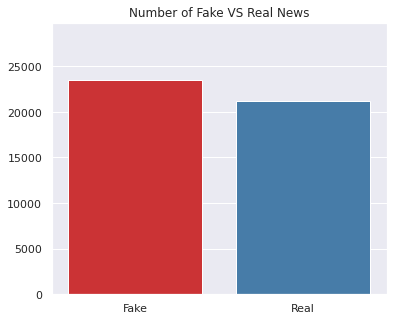

In [17]:
# check for imbalance in label
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='label')
plt.title('Number of Fake VS Real News')
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0, df.shape[0] / 1.5)
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

We can see that our data has similar number of fake and real news. Hence, the data is quite balanced and we won't need to oversample or undersample

## Splitting Dataset

We need to split the dataset into train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Split train and test set

In [18]:
# split sets to training+validation and testing sets
df_train_valid, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['label']
)

print('df_train_valid Size:', df_train_valid.shape)
print('df_test Size:', df_test.shape)

df_train_valid Size: (35751, 5)
df_test Size: (8938, 5)


### Split train and validation set

In [19]:
# split sets to training and validation sets
df_train, df_valid = train_test_split(
    df_train_valid,
    test_size=0.20,
    random_state=42,
    stratify=df_train_valid['label']
)

print('df_train Size:', df_train.shape)
print('df_valid Size:', df_valid.shape)

df_train Size: (28600, 5)
df_valid Size: (7151, 5)


In [20]:
# print datasets shape
print(f'df_train shape: {df_train.shape}')
print(f'df_valid shape: {df_valid.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (28600, 5)
df_valid shape: (7151, 5)
df_test shape: (8938, 5)


In [21]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Subjects

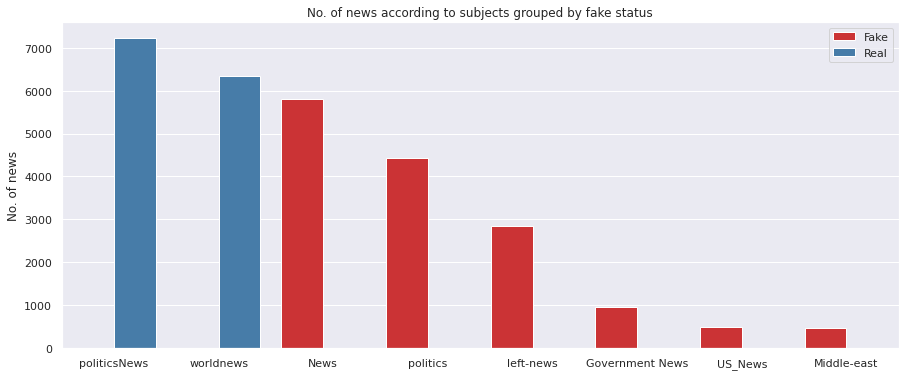

In [22]:
# plot number of news according to subjects
plt.figure(figsize=(15, 6))
sns.countplot(
    data=df_train,
    x='subject',
    hue='label',
    order=df_train['subject'].value_counts().index,
)
plt.title(f'No. of news according to subjects grouped by fake status')
plt.xlabel(None)
plt.ylabel('No. of news')

plt.legend(labels=['Fake', 'Real'])
plt.show()

We can see that real and fake news have totally different subjects. This might be a giveaway if we were to include this feature in our machine learning model later on

## Date

In [23]:
# attempt to convert date to datetime object to analyze time intervals
try:
    pd.to_datetime(df_train['date'])
except Exception as e:
    print(e)

Unknown string format: https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg


That's weird. Why would there be a string in a date feature? Let alone a link.\
Let's check for any links in the date feature

In [24]:
# check for dates which contains link
df_train[df_train['date'].str.contains('http')]

,title,text,subject,date,label
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0


There are 6 of them, and it's not just the date feature. The same links can also be found in the title and text features. This could be treated as missing values since they don't contain actually news

In [25]:
# convert date to datetime object and pass errors as NaT
df_train['date'] = pd.to_datetime(df_train['date'], errors='coerce')

# display the missing dates
df_train[df_train['date'].isna()]

,title,text,subject,date,label
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,0
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,0
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,0


What is that on loc 18933?

In [26]:
# display text at loc 18933
df_train['text'][18933]

'[vc_row][vc_column width= 1/1 ][td_block_trending_now limit= 5 ][td_block_big_grid sort= featured ][/vc_column][/vc_row][vc_row] [vc_column width= 2/3 ][td_block_5 limit= 24  custom_title= HOT OFF THE PRESS!  td_filter_default_txt= All  ajax_pagination= load_more  border_top= no_border_top ] [/vc_column][vc_column width= 1/3 ][vc_widget_sidebar sidebar_id= td-default ][/vc_column] [/vc_row][vc_row][vc_column width= 1/1 ][td_block_14 limit= 3  custom_title= EVEN MORE NEWS  td_filter_default_txt= All  ajax_pagination= next_prev  header_color= #288abf ][/vc_column] [/vc_row]'

Turns out that aside, from those 6 we checked, there's another one, with the text containing what seems to be a config at index 18933.\
We'll next check on to see if there's any other config style text

For now, let's continue our analysis on dates

In [27]:
# drop missing dates
df_train = df_train.dropna(subset=['date'])

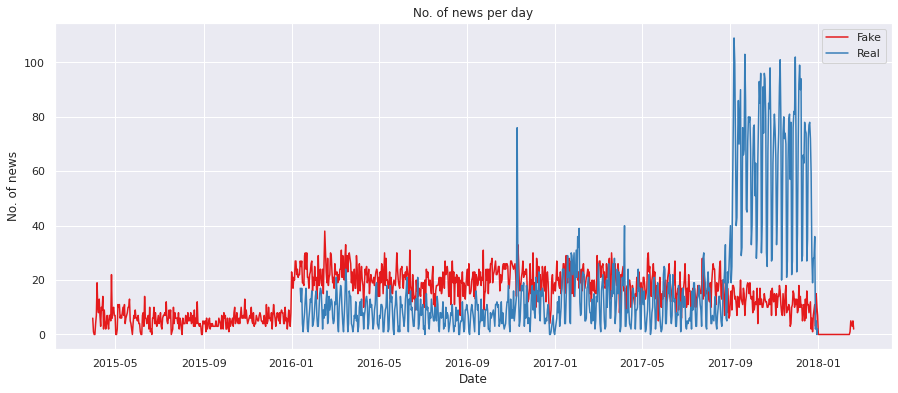

In [28]:
# count the number of news per day
fake_news_per_day = df_train[df_train['label'] == 0].groupby(pd.Grouper(key='date', freq='D'))['title'].count()
real_news_per_day = df_train[df_train['label'] == 1].groupby(pd.Grouper(key='date', freq='D'))['title'].count()

# plot the number of news per day
plt.figure(figsize=(15, 6))
plt.plot(fake_news_per_day, label='Fake')
plt.plot(real_news_per_day, label='Real')
plt.title('No. of news per day')
plt.xlabel('Date')
plt.ylabel('No. of news')
plt.legend()
plt.show()

We can see that the number of fake news have recently started to decrease, which is a good sign. The number of real news has also increased

## Square Bracket

Let's continue our analysis on square brackets, ergo that config style content

In [29]:
# display a text that contains square bracket
df_train[df_train['text'].str.contains(r'(\[.*\])', regex=True)].iloc[0]['text']

'President-elect Donald Trump s massive swamp now has a Russian accent. It s so bad that even a Fox News host called him out for siding with a hostile foreign government over U.S. intelligence agencies. And now, a former CIA director working on Trump s transition team has had it. He is done.The Washington Post reports:Former CIA director R. James Woolsey Jr., a veteran of four presidential administrations and one of the nation s leading intelligence experts, resigned Thursday from President-elect Donald Trump s transition team because of growing tensions over Trump s vision for intelligence agencies.Woolsey s resignation as a Trump senior adviser comes amid Trump s public comments undermining the intelligence community. Trump has publicly aligned himself with Russia over the U.S., even in his Twitter timeline. Effective immediately, Ambassador Woolsey is no longer a Senior Advisor to President-Elect Trump or the Transition. He wishes the President-Elect and his Administration great suc

Seems like this is normal news, which contains a square bracket to make the sentence more readable. So I'm not going to deliberately drop all entries containing square brackets

## Corpus

In [30]:
# display the first instance of the dataset
df_train.iloc[0]

title       This Fantastic Obama Speech Shows Us How A RE...
text       We just took a massive step closer to nuclear ...
subject                                                 News
date                                     2017-08-09 00:00:00
label                                                      0
Name: 604, dtype: object

In [31]:
# display the title of the first instance 
df_train.iloc[0]['title']

' This Fantastic Obama Speech Shows Us How A REAL President Would Be Acting Right Now (VIDEO)'

In [32]:
# display the title of the first text 
df_train.iloc[0]['text']

'We just took a massive step closer to nuclear war with North Korea, and while Secretary of State Rex Tillerson keeps trying to reassure our allies that we re trying to bring North Korea to the negotiating table rather than just annihilate the entire planet, Trump is still posturing like a male peacock fanning his tail feathers. We don t need a peacock. We need a diplomat. Here s why:BREAKING: North Korea says it will complete plan to attack waters near Guam by mid-August then wait for commander in chief s order.  The Associated Press (@AP) August 9, 2017So the Georgia Democratic Party decided to remind us of exactly what a real president would be doing right now. President Obama, who believed in the diplomacy that Trump s immature machismo says is simply weakness (because why try diplomacy when you can fan your peacock feathers and strut?), always spoke eloquently on U.S. foreign policy and on war, and emphasized the necessity of working with the rest of the world to neutralize threat

It seems like `title` and `text` are two features which make the most important content of the news. Since NLP are performed on a body of text, I'm only going to use one feature, so I'm going to combine these features into one later on.

There seems to be some twitter username mention and twitter hashtags as well. There's also a link to a picture on twitter. It seems like these are a tweet embedded into the news. Let's find out how many news are there that contains these embedded tweets by searching the user mentions and hashtags

## Embedded Tweets

In [33]:
# create a new column to label whethe there is a tweet in the text
df_train['has_tweet'] = df_train['text'].str.contains(r'(@|#)([A-Za-z0-9_]+)', regex=True)

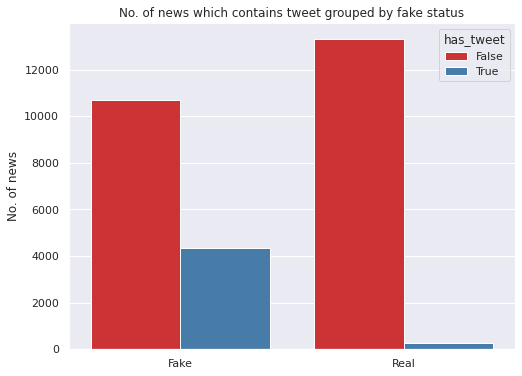

In [34]:
# plot number of news that has tweet
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_train,
    x='label',
    hue='has_tweet',
)
plt.title(f'No. of news which contains tweet grouped by fake status')
plt.xlabel(None)
plt.ylabel('No. of news')
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

We can see that though most news do not contain any tweets embedded, fake news have a higher tendency to have one compared to real news.\
This makes the data quite imbalanced, since there are clear characteristics that are leaning towards one label.

According to this [kaggle research](https://www.kaggle.com/code/josutk/only-one-word-99-2#2), it could be caused by fake news sourcing their content from twitter.

## Wordcloud

In [35]:
# create word cloud object
wc =  WordCloud(max_words=2000, stopwords=STOPWORDS, random_state=42)

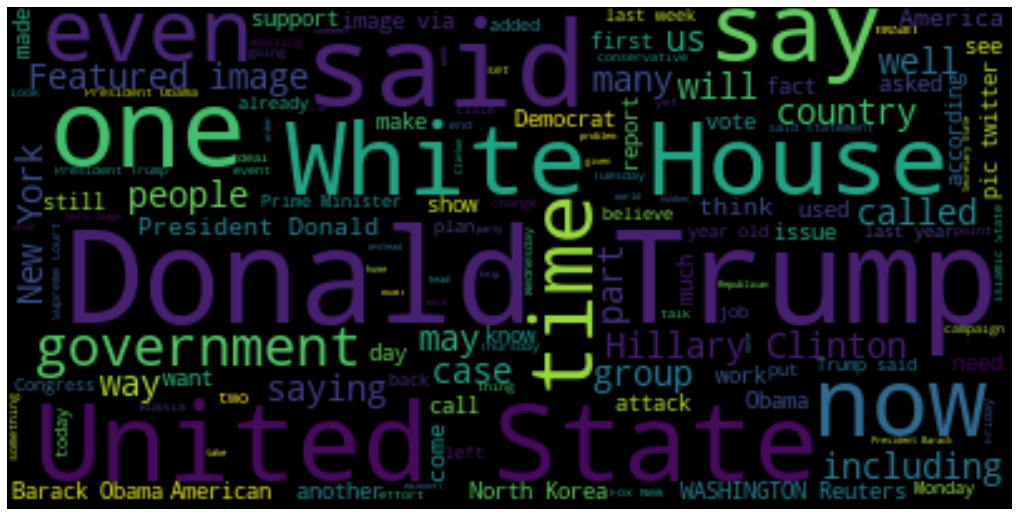

In [36]:
# generate word cloud
wc.generate(' '.join(df_train['text']))

# plot wordcloud
plt.figure(figsize=(18, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that `Donald Trump`, `said`, and `United State` show up quite often.\
Let's separate between the fake and real news and see how they differ

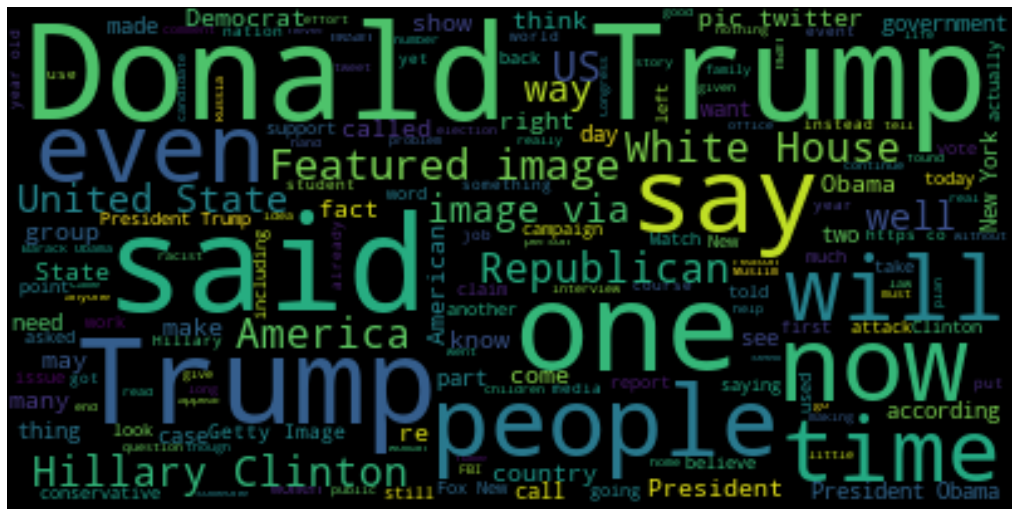

In [37]:
# generate word cloud for fake news
wc.generate(' '.join(df_train[df_train['label'] == 0]['text']))

# plot wordcloud
plt.figure(figsize=(18, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

For fake news, it's pretty similar to the overall set with `Donald Trump` and `said` that popped out

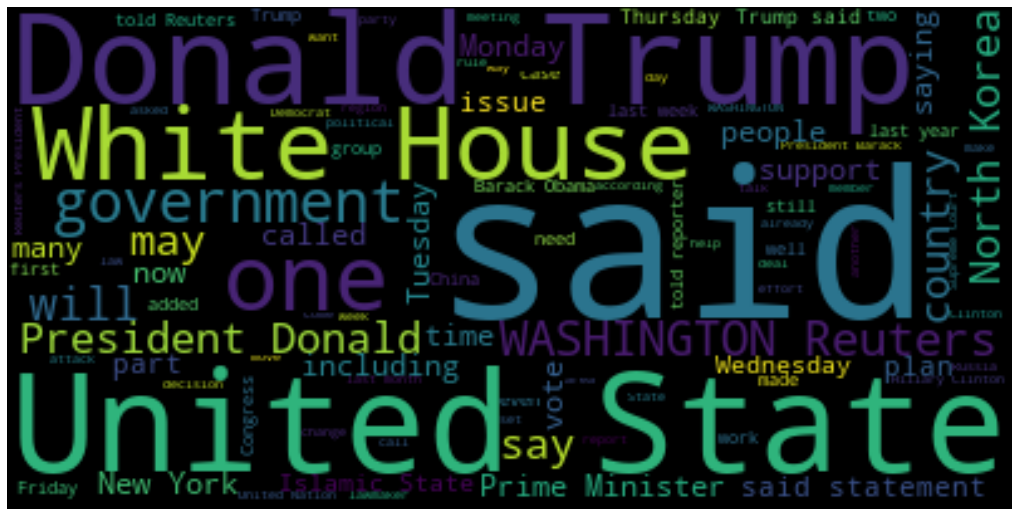

In [38]:
# generate word cloud
wc.generate(' '.join(df_train[df_train['label'] == 1]['text']))

# plot wordcloud
plt.figure(figsize=(18, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

For real news, there doesn't seem to be many differences compared to those of fake news either, with `said`, `United State`, and `Donald Trump` being prominent

## Number of Words

In [39]:
# create a feature to store the number of words in the text feature
df_train['words'] = df_train['text'].str.split().apply(len)

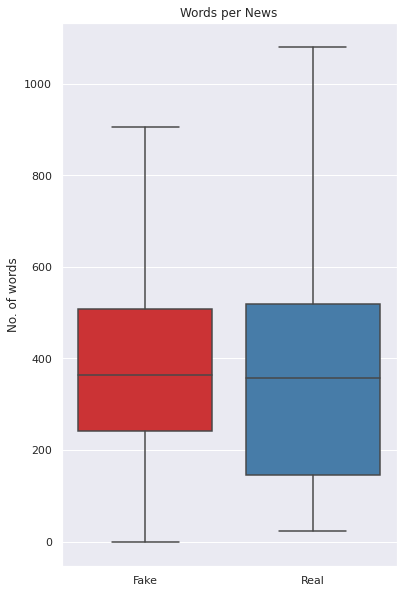

In [40]:
# plot number of words
plt.figure(figsize=(6, 10))
sns.boxplot(data=df_train, x='label', y='words', showfliers=False)
plt.title(f'Words per News')
plt.xlabel(None)
plt.ylabel('No. of words')
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

We can see that both fake and real news have about 400 words in their body of text. However, the first quartile for real news is lower than that of fake news\
However, we had the outliers hidden for that plot, now let's show them

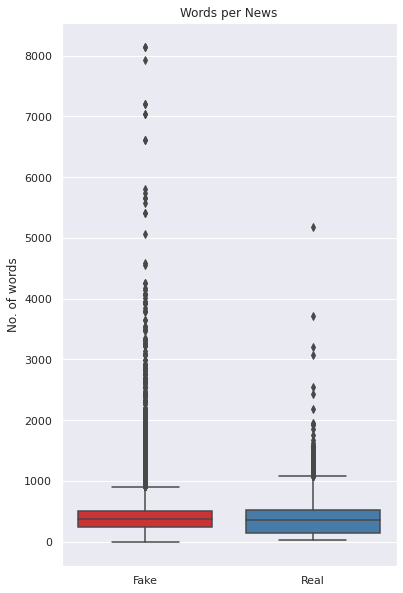

In [41]:
# plot number of words
plt.figure(figsize=(6, 10))
sns.boxplot(data=df_train, x='label', y='words', showfliers=True)
plt.title(f'Words per News')
plt.xlabel(None)
plt.ylabel('No. of words')
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

It's now a totally different story. We can see that there are a couple fake news which have a lot more words compared to real news

## Unique Words

In [42]:
# create a feature to store the number of words in the text feature
df_train['unique_words'] = df_train['text'].str.split().apply(np.unique).apply(len)

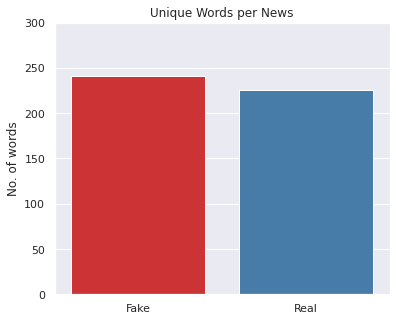

In [43]:
# plot number of unique words
plt.figure(figsize=(6, 5))
sns.barplot(data=df_train, x='label', y='unique_words', ci=None)
plt.title(f'Unique Words per News')
plt.xlabel(None)
plt.ylabel('No. of words')
plt.ylim(0, 300)
plt.xticks([0, 1], ['Fake', 'Real'])

plt.show()

The number of unique words in fake news is slightly higher than in real news

# 5. Data Preprocessing

In [44]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [45]:
# split between features and label
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label'].copy()

X_valid = df_valid.drop(['label'], axis=1)
y_valid = df_valid['label'].copy()

X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label'].copy()

## Handling Missing Values

We don't have any nan missing values. However, we found out during our EDA that some instances in our dataset contains nothing but links. Therefore, we are going to drop these entries as they do not provide any value in 

In [46]:
# check links only value in train set
check_links_only(X_train)

,feats,tot_missing,tot_missing_pct
0,title,6,0.02
1,text,51,0.18
2,date,6,0.02


In [47]:
# check links only value in validation set
check_links_only(X_valid)

,feats,tot_missing,tot_missing_pct
0,text,11,0.15


In [48]:
# check links only value in test set
check_links_only(X_test)

,feats,tot_missing,tot_missing_pct
0,title,3,0.03
1,text,20,0.22
2,date,3,0.03


It seems like there are some instances of data whose title is not link, but the text contains only link. Let's check these data

In [49]:
# display the first five rows of data which have normal titles, but link in text
X_train[
    ~(X_train['title'].str.contains(r'^https?:\S+$', regex=True)) &
    (X_train['text'].str.contains(r'^https?:\S+$', regex=True))
].head()

,title,text,subject,date
19262,WOW! CHUCK TODD Goes After Nasty Chuck Schumer...,https://www.youtube.com/watch?v=EOr9fwoc_mo,left-news,"Jan 22, 2017"
11736,RADICAL DIRECTOR OF SIERRA CLUB: Abortion is t...,https://www.youtube.com/watch?time_continue=13...,politics,"Feb 4, 2017"
11882,HEATED! TUCKER CARLSON Totally Shuts Down Radi...,https://www.youtube.com/watch?v=RRPSCqkAJgk,politics,"Jan 17, 2017"
19047,NEWT GINGRICH Punches Back At Democrats With M...,https://www.youtube.com/watch?v=PjeOoJyPNCk,left-news,"Mar 3, 2017"
12315,WOW! Leftist Bully ROSIE O’DONNELL PUSHES Horr...,https://twitter.com/Rosie/status/8009393386158...,politics,"Nov 23, 2016"


It seems like the links in the text point out to different websites.\
I'm not going to drop these kinds of instances, since the values in the title feature could still be useful as predictors.

Therefore, I'm only dropping instances of data which title is links. However we also had that entries at loc 18933 which is considered missing, but it doesn't contain links in the title. It just had missing date. Hence, all missing dates have missing titles, but not all titles which are links, have missing dates.

Conclusion, we also need to drop those instances of data which dates passed as missing when converted

In [50]:
# list of features that we want to impute
impute_cols = ['title']

In [51]:
# print dataset shape before handling links in title
print('X_train and y_train shape before handling links in title:', X_train.shape, y_train.shape)
print('X_valid and y_valid shape before handling links in title:', X_valid.shape, y_valid.shape)
print('X_test and y_test shape before handling links in title:', X_test.shape, y_test.shape)

print('=' * 80)

# drop instances of data which has link as its title
X_train, y_train_final = drop_missing_news(X_train, 'date', impute_cols, y_train)
X_valid, y_valid_final = drop_missing_news(X_valid, 'date', impute_cols, y_valid)
X_test, y_test_final = drop_missing_news(X_test, 'date', impute_cols, y_test)

# print dataset shape after handling links in title
print('X_train and y_train_final shape after handling links in title:', X_train.shape, y_train_final.shape)
print('X_valid and y_valid_final shape after handling links in title:', X_valid.shape, y_valid_final.shape)
print('X_test and y_test_final shape after handling links in title:', X_test.shape, y_test_final.shape)

X_train and y_train shape before handling links in title: (28600, 4) (28600,)
X_valid and y_valid shape before handling links in title: (7151, 4) (7151,)
X_test and y_test shape before handling links in title: (8938, 4) (8938,)
X_train and y_train_final shape after handling links in title: (28593, 4) (28593,)
X_valid and y_valid_final shape after handling links in title: (7151, 4) (7151,)
X_test and y_test_final shape after handling links in title: (8935, 4) (8935,)


Great! We have no more missing values

## Feature Selection

In [52]:
# display the first five rows of the train set
X_train.head()

,title,text,subject,date
604,This Fantastic Obama Speech Shows Us How A RE...,We just took a massive step closer to nuclear ...,News,2017-08-09
20996,DISTURBING TRUTH ABOUT How The UN Decides Whic...,Every American should know the corrupt UN has ...,left-news,2016-02-16
34761,"Tillerson, Lavrov agree to continue North Kore...",WASHINGTON (Reuters) - The United States and R...,worldnews,2017-12-27
28665,Cabinet members lobby Trump to remove Iraq fro...,WASHINGTON (Reuters) - Senior Cabinet members ...,politicsNews,2017-03-02
44461,"In Athens, Macron to urge renewal of EU democracy",PARIS (Reuters) - French President Emmanuel Ma...,worldnews,2017-09-05


- We mentioned that we are going to combine the `title` and `text` features since they both make up the major part of a news
- We're going to drop `subject`, since we found out during our EDA that fake and real news have totally different subjects
- We're also going to drop `date`, since date do not have any influence in an NLP model. We're not attempting to find a pattern on when a fake news might be released. We're attempting to spot a fake news based on its content
- Therefore, our dataset will only contain the feature which contains news from `title` and `text`

In [53]:
# combine title and text features as news
X_train_combined = combine_text(X_train, 'news', 'title', 'text')
X_valid_combined = combine_text(X_valid, 'news', 'title', 'text')
X_test_combined = combine_text(X_test, 'news', 'title', 'text')

# keep only the news feature as the only text to process
X_train_combined = X_train_combined['news']
X_valid_combined = X_valid_combined['news']
X_test_combined = X_test_combined['news']

# print datasets shape
print(f'X_train_combined shape: {X_train_combined.shape}')
print(f'X_valid_combined shape: {X_valid_combined.shape}')
print(f'X_test_combined shape: {X_test_combined.shape}')

X_train_combined shape: (28593,)
X_valid_combined shape: (7151,)
X_test_combined shape: (8935,)


## Text Preprocessing

In [54]:
# display the first five rows of the train set
X_train_combined.head()

604       This Fantastic Obama Speech Shows Us How A RE...
20996    DISTURBING TRUTH ABOUT How The UN Decides Whic...
34761    Tillerson, Lavrov agree to continue North Kore...
28665    Cabinet members lobby Trump to remove Iraq fro...
44461    In Athens, Macron to urge renewal of EU democr...
Name: news, dtype: object

In [55]:
%%time

# clean text
X_train_cleaned = X_train_combined.apply(clean_text)
X_valid_cleaned = X_valid_combined.apply(clean_text)
X_test_cleaned = X_test_combined.apply(clean_text)

# lemmatize text
X_train_lemmatized = X_train_cleaned.apply(lemmatize_text)
X_valid_lemmatized = X_valid_cleaned.apply(lemmatize_text)
X_test_lemmatized = X_test_cleaned.apply(lemmatize_text)

CPU times: user 3min 34s, sys: 603 ms, total: 3min 35s
Wall time: 3min 38s


I've decided to use only `title` and `text`, while dropping `date` and `subject` because they are not needed in an NLP model.\
I also decided to clean and use lemmatization instead of stemming, since it would make the model or accurate and retain the meaning of the text.

## Create TensorFlow input pipelines

In [56]:
# define final dataset
X_train_final = X_train_lemmatized
X_valid_final = X_valid_lemmatized
X_test_final = X_test_lemmatized

In [57]:
# define batch size
batch_size = 64

# create tf dataset instance 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_final, y_valid_final))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test_final))

# shuffle tf train dataset instance
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_final), seed=42)

# cache tf dataset instance
train_dataset = train_dataset.cache()
valid_dataset = valid_dataset.cache()   
test_dataset = test_dataset.cache()

# create tf dataset instance with batch size
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# prefetch tf dataset instance
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Tokenization

In [58]:
# declare vectorizer object
Vectorize = CountVectorizer()

# fit vectorize object to the train set
Vectorize.fit(X_train_final)

CountVectorizer()

In [59]:
# display some information about the vocabs
print(f'There are {len(Vectorize.vocabulary_.keys())} vocabulary')
print('These are some of them:')
print(list(Vectorize.vocabulary_.keys())[:10])

There are 87071 vocabulary
These are some of them:
['fantastic', 'obama', 'speech', 'shows', 'real', 'president', 'acting', 'right', 'video', 'took']


In [60]:
# display the top ten most occurence vocabs
sorted(Vectorize.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:10]

[('zzzzzzzz', 87070),
 ('zzuml', 87069),
 ('zzqvyk', 87068),
 ('zzpxelb', 87067),
 ('zzomtmd', 87066),
 ('zzn', 87065),
 ('zzll', 87064),
 ('zzjjpdaivn', 87063),
 ('zzg', 87062),
 ('zz', 87061)]

What what is this. Why are the top ten words gibberish? Let's take another look at the original text before cleaning and tokenizing

### Gibberish words

In [61]:
# searching for text which contains `zz....`
df_train[df_train['text'].str.contains(r'(z{2,})', regex=True)]

,title,text,subject,date,label
15896,JUST IN: Mystery Surrounds Obama Appointee Jud...,"A federal judge in Washington, D.C. has recuse...",Government News,"Dec 16, 2017",0
35136,Myanmar bars U.N. rights investigator before v...,GENEVA (Reuters) - The U.N. independent invest...,worldnews,"December 20, 2017",1
22913,NSA – ‘Top Secret’ Arsenal Released In Protest...,21st Century Wire says Out of all the intellig...,Middle-east,"April 9, 2017",0
30185,Senate fight looms after Trump taps Exxon CEO ...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"December 12, 2016",1
12920,BILL CLINTON’S 12-YR Mistress Gennifer Flowers...,Donald Trump on Saturday threatened to bring a...,politics,"Sep 24, 2016",0
...,...,...,...,...,...
10870,CLUELESS NBA COACH’S Rant Comparing Trump To A...,"In the realm of the NBA, Spurs head coach Greg...",politics,"May 16, 2017",0
12407,RIOTERS CHASE DOWN Trump Supporter’s Truck…Att...,Portland rioters have been chasing a Trump sup...,politics,"Nov 13, 2016",0
5985,"RNC Shoots Out Weak, Loser-y Response To Seei...",How damaging is Donald Trump? Just ask the Rep...,News,"June 6, 2016",0
10216,ERIC BOLLING Accuser Is Serial Sexual Harassme...,"Yesterday, Fox News announced that they were s...",politics,"Aug 6, 2017",0


There are 777 instances of these. This is weird. Let's group them by labels

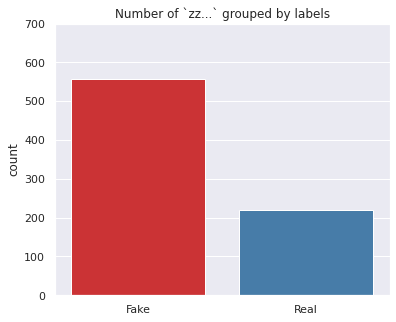

In [62]:
# searching for text which contains `zz....`
plt.figure(figsize=(6, 5))
sns.countplot(
    data=df_train[df_train['text'].str.contains(r'(z{2,})', regex=True)],
    x='label'
)
plt.title('Number of `zz...` grouped by labels')
plt.xlabel(None)
plt.ylim(0, 700)
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

As I thought. Most of them are from fake news.\
Let's continue. We are just going to leave them as they are for now

In [63]:
# define percentage of vocab to include
pct_vocab = 0.75

# define max number of features to include
max_features = int(np.floor(0.75 * len(Vectorize.vocabulary_.keys())))

# define max number of sequence length based on mean sentence length
max_seq_length = int(np.floor(np.mean([len(i.split(' ')) for i in X_train_final])))

# print max number of vocabs and output sequence length
print(f'Max number of vocabs: {max_features}')
print(f'Output sequence length: {max_seq_length}')

Max number of vocabs: 65303
Output sequence length: 364


## TextVectorization

Vectorize the text and adapt it to the train set

In [64]:
# define text vectorizer layer
text_vectorizer = TextVectorization(
    max_tokens=max_features,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=max_seq_length,
)

# adapt vectorization layer to the train set
text_vectorizer.adapt(X_train_final)

## Embedding

Create a layer to map the vocabulary into a dense vector for the model 

In [65]:
# define embbeding layer
embedding_layer = Embedding(
    input_dim=max_features,
    output_dim=256,
    input_length=max_seq_length,
)

# 6. Model Definition

- Target: Detecting whether the news is fake or not

    The target that we're going to predict is a label, which means we are going to make a classification model.
    In this case, we want to minimize the situation in which we incorrectly predicts a news to be real, when it is in fact fake, or as in the statistical term, **False Negatives**.

    This prediction is made so that we can identify fake news, and attempt to take them down as soon as possible.

    We don't want to misclassify a news as real and let them circulate, spreading fake news to everybody

- Predictors: The features I'm going to use are the news title and the body of text


- Models: I'm going to use Neural Network algorithm using keras

## DNN Model

Running the DNN model as a base with one dense layer with 64 neurons.\
I also use l2 to reduce overfit

In [66]:
# instantiate input object
inputs = Input(shape=(1,), dtype=tf.string)

# preprocess inputs
preprocessed_inputs = text_vectorizer(inputs)

# apply model layers
x = embedding_layer(preprocessed_inputs)
x = Dropout(rate=0.2, seed=42)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(rate=0.2, seed=42)(x)
x = Dense(
    units=64, activation='relu',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
)(x)
x = Dropout(rate=0.2, seed=42)(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_dnn = Model(inputs=inputs, outputs=outputs)

# compile model
model_dnn.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

# display model summary for functional model
model_dnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 364)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 364, 256)          16717568  
                                                                 
 dropout (Dropout)           (None, 364, 256)          0         
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

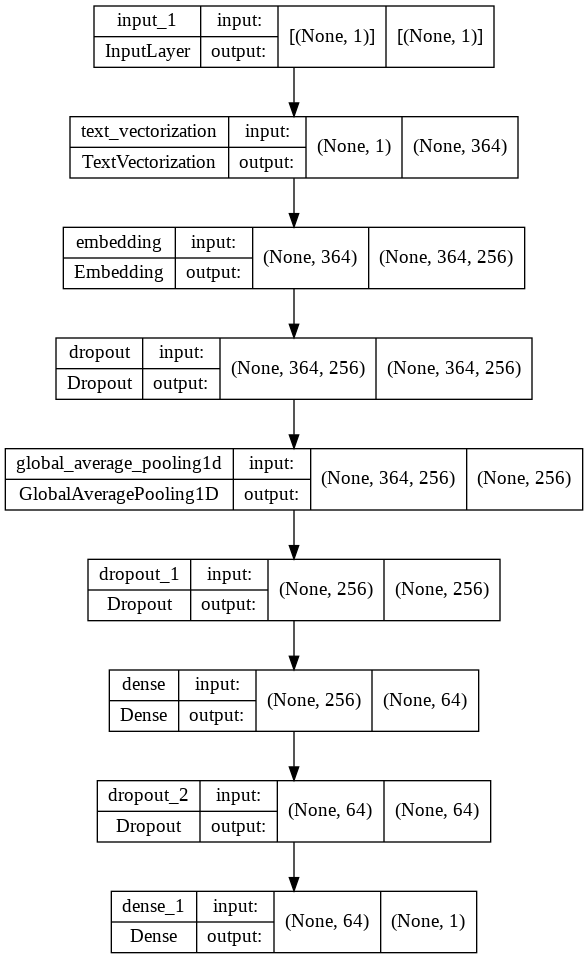

In [67]:
# plot model architecture
keras.utils.plot_model(model_dnn, show_shapes=True)

## LSTM Model

Attempting to improve the model using RNN LSTM model using three layers with 64 neurons.\
I also perform gradient clipping and use Adamax as optimizer to reduce exploding gradient problems

In [68]:
# instantiate input object
inputs = Input(shape=(1,), dtype=tf.string)

# preprocess inputs
preprocessed_inputs = text_vectorizer(inputs)

# apply model layers
x = embedding_layer(preprocessed_inputs)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
x = LSTM(
    units=64, activation='tanh',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
    return_sequences=True,
)(x)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
x = LSTM(
    units=64, activation='tanh',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
    return_sequences=True,
)(x)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
x = LSTM(
    units=64, activation='tanh',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
)(x)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_lstm = Model(inputs=inputs, outputs=outputs)

# compile model
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adamax(lr=0.001, clipnorm=1.0),
    metrics=['accuracy']
)

# display model summary for functional model
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 364)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 364, 256)          16717568  
                                                                 
 dropout_3 (Dropout)         (None, 364, 256)          0         
                                                                 
 batch_normalization (BatchN  (None, 364, 256)         1024      
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 364, 64)           8217

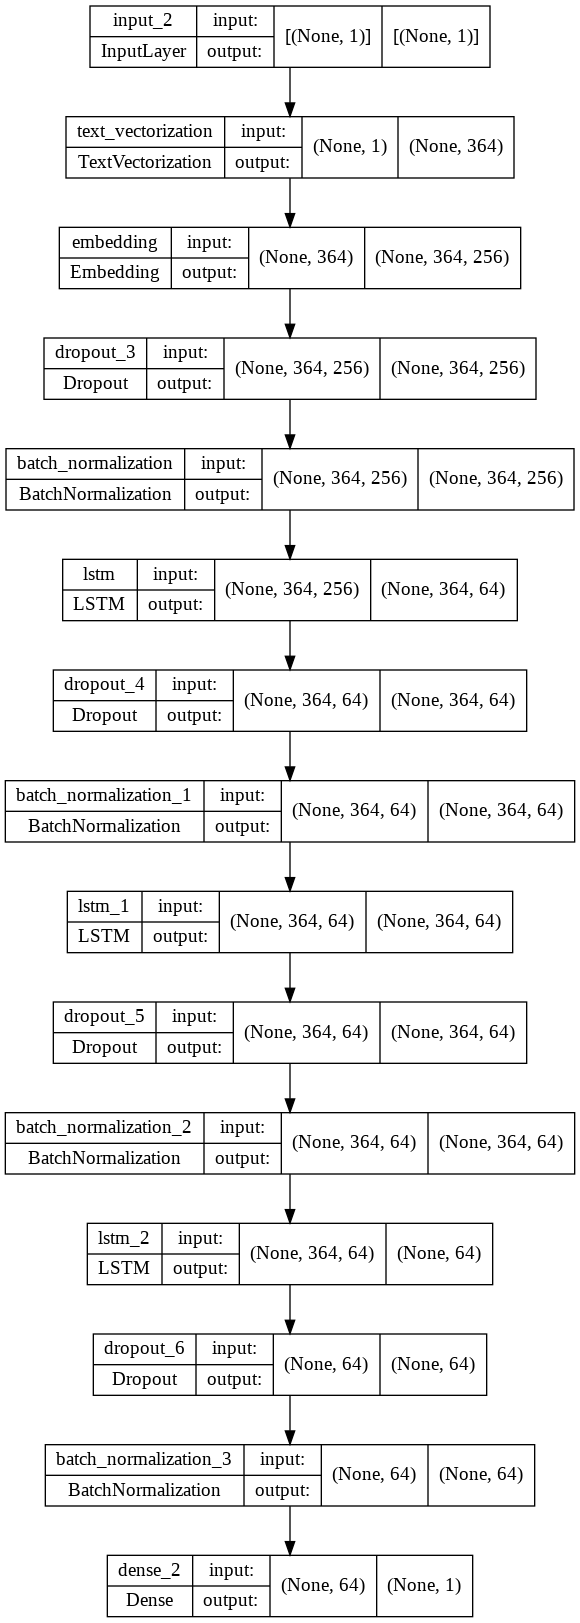

In [69]:
# plot model architecture
keras.utils.plot_model(model_lstm, show_shapes=True)

## GRU Model

Attempting to improve the model using RNN GRU model using three layers with 64 neurons, trying to make it similar to LSTM.

In [70]:
# instantiate input object
inputs = Input(shape=(1,), dtype=tf.string)

# preprocess inputs
preprocessed_inputs = text_vectorizer(inputs)

# apply model layers
x = embedding_layer(preprocessed_inputs)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
x = GRU(
    units=64, activation='tanh',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
    return_sequences=True,
)(x)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
x = GRU(
    units=64, activation='tanh',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
    return_sequences=True,
)(x)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
x = GRU(
    units=64, activation='tanh',
    kernel_initializer=keras.initializers.he_normal(seed=42),
    kernel_regularizer=keras.regularizers.l2(0.01),
)(x)
x = Dropout(rate=0.2, seed=42)(x)
x = BatchNormalization()(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_gru = Model(inputs=inputs, outputs=outputs)

# compile model
model_gru.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adamax(lr=0.001, clipnorm=1.0),
    metrics=['accuracy']
)

# display model summary for functional model
model_gru.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 364)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 364, 256)          16717568  
                                                                 
 dropout_7 (Dropout)         (None, 364, 256)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 364, 256)         1024      
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 364, 64)           6182

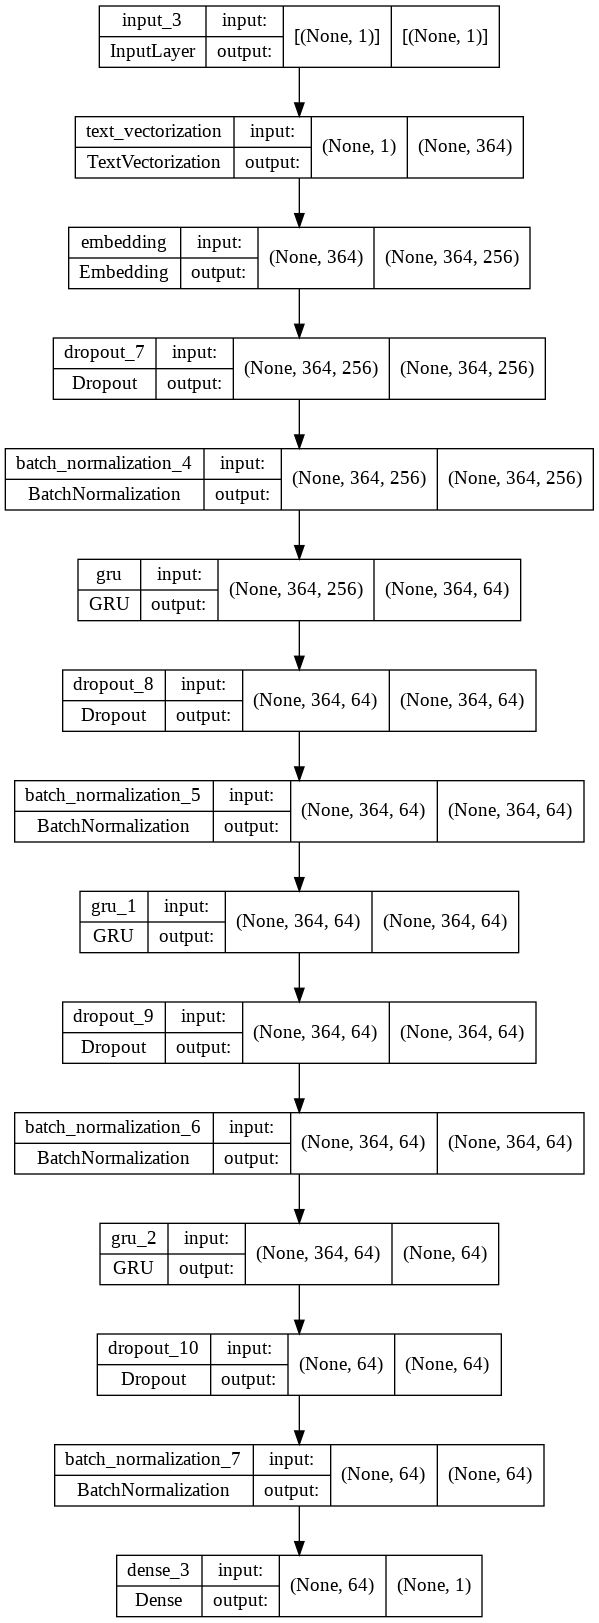

In [71]:
# plot model architecture
keras.utils.plot_model(model_gru, show_shapes=True)

## Callbacks objects

In [72]:
# define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

# 7. Model Training

In [73]:
# create dictionary of models
models = {
    'dnn': model_dnn,
    'lstm': model_lstm,
    'gru': model_gru,
}

In [74]:
%%time

# create dictionary to store metrics
metrics = {}

# loop through models and train
for name, model in models.items():
    # train model
    history = model.fit(
        train_dataset,
        epochs=30,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0
    )

    # store metrics
    metrics[name] = pd.DataFrame(history.history)

CPU times: user 17min 59s, sys: 44 s, total: 18min 43s
Wall time: 17min 23s


# 8. Model Evaluation

In [75]:
# create dictionary to store evaluation metrics
eval_metrics = {
    'dnn': {},
    'lstm': {},
    'gru': {},
}

# loop through models and evaluate them
for name, model in models.items():
    # evaluate model
    eval_metrics[name]['loss'], eval_metrics[name]['accuracy'] = model.evaluate(
        test_dataset,
        verbose=0
    )

# create dataframe from evaluation metrics
eval_metrics_df = pd.DataFrame(eval_metrics).T

# display evaluation metrics
eval_metrics_df

,loss,accuracy
dnn,0.02,1.00
lstm,0.04,0.99
gru,0.02,1.00


A near 100% accuracy? This is really suspicious

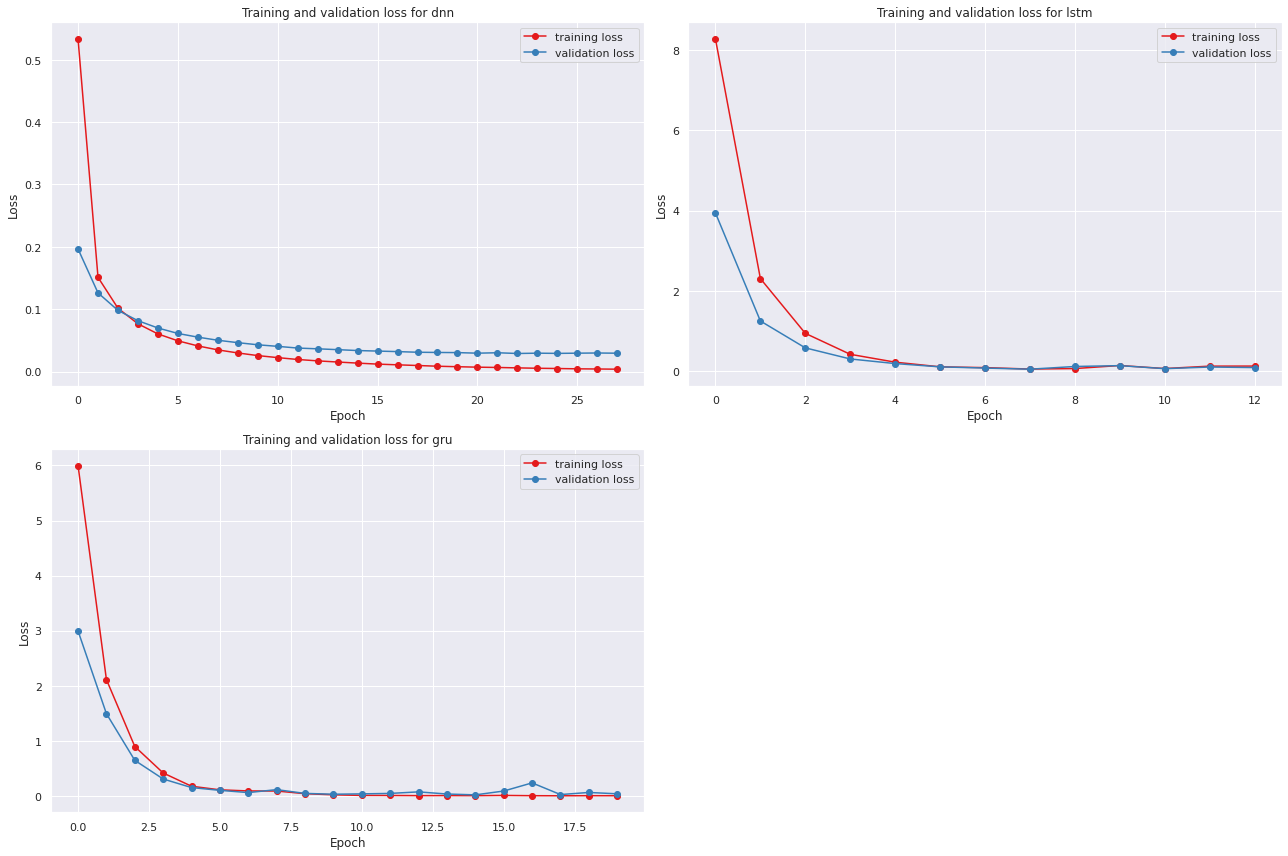

In [76]:
plt.figure(figsize=(18, 12))

# plot the loss curves
for i, (name, metric) in enumerate(metrics.items()):
    plt.subplot(2, 2, i + 1)
    plot_loss(metric)
    plt.title(f'Training and validation loss for {name}')

plt.tight_layout()
plt.show()

- We can see that the DNN model is much smoother compared to the RNN models
- LSTM model is also quite good, though not quite as smooth
- GRU still have a bit of exploding gradient at epoch 16, though they eventually converged later on

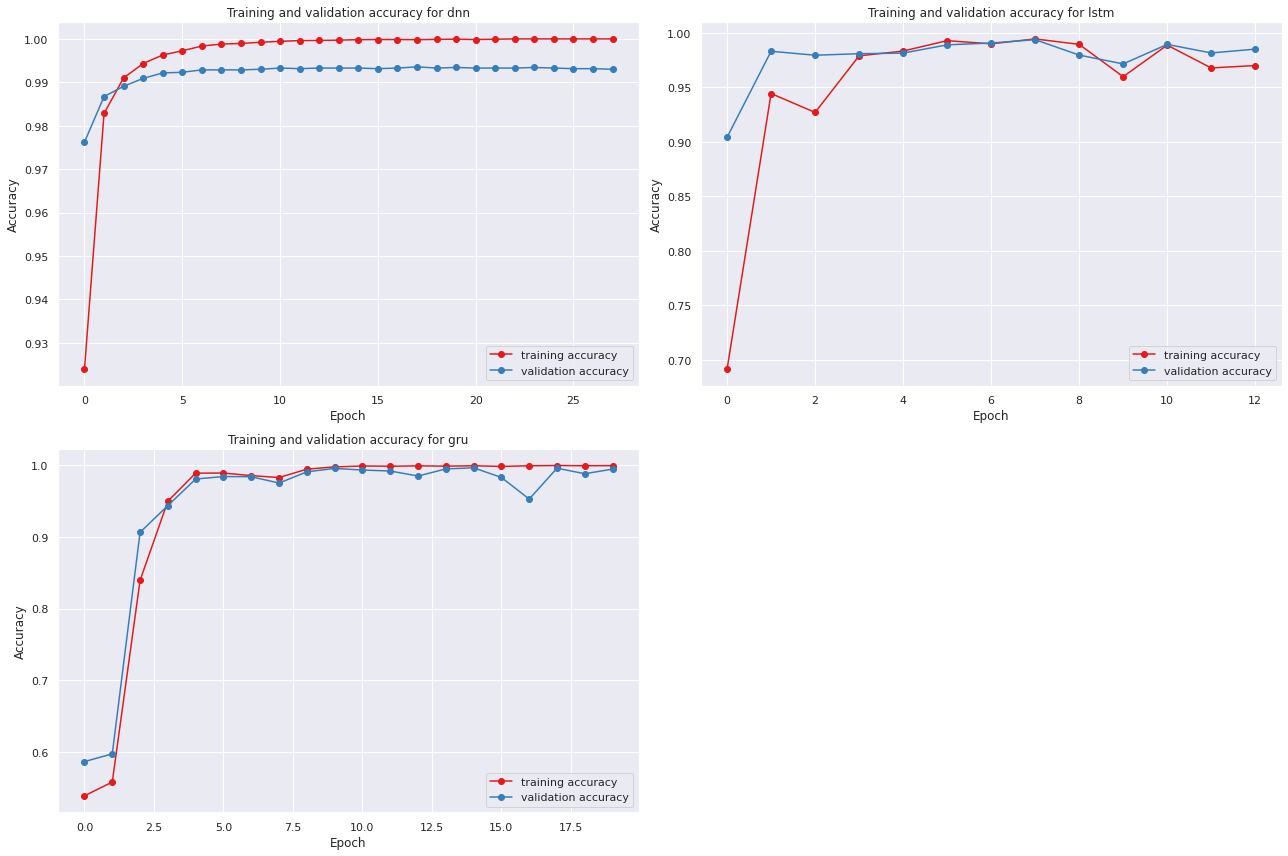

In [77]:
plt.figure(figsize=(18, 12))

# plot the accuracy curves
for i, (name, metric) in enumerate(metrics.items()):
    plt.subplot(2, 2, i + 1)
    plot_acc(metric)
    plt.title(f'Training and validation accuracy for {name}')

plt.tight_layout()
plt.show()

- We can see that the accuracy for DNN is also more stable
- LSTM's and GRU's accuracy dropped quite a bit during some iteration

## Prepare Evaluation

In [78]:
# set threshold for prediction
threshold = 0.5

# create dictionary to store predictions:
predictions = {
    'dnn': {},
    'lstm': {},
    'gru': {},
}

# loop through models and make predictions
for name, model in models.items():
    # make predictions for training set
    pred_train = model.predict(X_train_final).reshape(-1)
    pred_train = np.where(pred_train > threshold, 1, 0)

    # make predictions for test set
    pred_test = model.predict(X_test_final).reshape(-1)
    pred_test = np.where(pred_test > threshold, 1, 0)

    # store predictions in dictionary
    predictions[name]['train'] = pred_train
    predictions[name]['test'] = pred_test

In [79]:
# prepare target names for classification report
target_names = ["Fake", "Real"]

## DNN Evaluation

In [80]:
# print classification report for dnn model
for name, preds in predictions.items():
    if 'dnn' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

dnn classification report for training set:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     15018
        Real       1.00      1.00      1.00     13575

    accuracy                           1.00     28593
   macro avg       1.00      1.00      1.00     28593
weighted avg       1.00      1.00      1.00     28593

dnn classification report for testing set:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4693
        Real       0.99      1.00      1.00      4242

    accuracy                           1.00      8935
   macro avg       1.00      1.00      1.00      8935
weighted avg       1.00      1.00      1.00      8935



- This is very suspicious. Our model reported a 100% accuracy and recall on fake news detection 
- According to this [kaggle research](https://www.kaggle.com/code/josutk/only-one-word-99-2), it could be caused by many features which is biased towards fake news, which makes the dataset extremely simple and could produce high results without much engineering

## LSTM Evaluation

In [81]:
# print classification report for lstm model
for name, preds in predictions.items():
    if 'lstm' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

lstm classification report for training set:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     15018
        Real       1.00      1.00      1.00     13575

    accuracy                           1.00     28593
   macro avg       1.00      1.00      1.00     28593
weighted avg       1.00      1.00      1.00     28593

lstm classification report for testing set:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4693
        Real       0.99      0.99      0.99      4242

    accuracy                           0.99      8935
   macro avg       0.99      0.99      0.99      8935
weighted avg       0.99      0.99      0.99      8935



- Much like the DNN model, the LSTM model also produced similar results
- As it's said, garbage in, garbage out. Or in this case, simple model resulted in an unbelievably good results, though questionable and might be deceptive

## GRU Model Evaluation

In [82]:
# print classification report for gru model
for name, preds in predictions.items():
    if 'gru' not in name:
        continue
    for dataset, pred in preds.items():
        if dataset == 'train':
            print(f'{name} classification report for training set:')
            print(classification_report(y_train_final, pred, target_names=target_names))
        if dataset == 'test':
            print(f'{name} classification report for testing set:')
            print(classification_report(y_test_final, pred, target_names=target_names))

gru classification report for training set:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     15018
        Real       1.00      1.00      1.00     13575

    accuracy                           1.00     28593
   macro avg       1.00      1.00      1.00     28593
weighted avg       1.00      1.00      1.00     28593

gru classification report for testing set:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4693
        Real       0.99      1.00      1.00      4242

    accuracy                           1.00      8935
   macro avg       1.00      1.00      1.00      8935
weighted avg       1.00      1.00      1.00      8935



- Similar results with LSTM and DNN, all the metrics returned 100%

## Analysis
- Quality of data is very important in modeling, as the concept of garbage in, garbage out
- Since the dataset has biased words such as `said` or `reuters` ([source](https://www.kaggle.com/code/josutk/only-one-word-99-2#4)), which could predict the fake news with high accuracy

## Save The Final Model

Though all models might be deceptively good, I'm choosing the simple DNN model since its validation loss graph was smooth without exploding gradient

In [83]:
# timestamp
timestamp_now = datetime.now().strftime('%Y%m%d-%H%M%S')

# prepare directory for saving model
model_dir = f'models-{timestamp_now}'
model_name = 'nlp_model'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# define model path
model_path = Path(model_dir, model_name)

# save model
model_dnn.save(model_path)

INFO:tensorflow:Assets written to: models-20220627-075443/nlp_model/assets


# 9. Model Inference

## Load The Model

In [84]:
# model location
model_dir = f'models-{timestamp_now}'
model_name = 'nlp_model'

# create path object
model_path = Path(model_dir, model_name)

# load model
model = keras.models.load_model(model_path)

## Prepare Data For Inferencing

In [85]:
# prepare data for inferencing
inf_title = " WATCH: Kieth Scott’s Wife Drops Mic On Cops, Gives Video Of Husband’s Final Moments To Press"
inf_text = "What you are about to see is disturbing. Keith Lamont Scott, the man killed by police in Charlotte, North Carolina had an awesome wife of 20 years who narrated and recorded the final tragic moments of his life. Mr. Scott suffered from a traumatic brain injury, and his wife repeatedly told the police this information in the minutes prior to the shooting. She also told them that he had no weapon, and that he had just taken his medication. Of course, the cops just kept shouting at the man to drop the gun that he didn t have, before taking his life for no reason.Well, the cat s out of the bag now. NBC News has the video, so, despite the fact that the cops and the City of Charlotte have been refusing to take the public s demands for transparency seriously, the information is now out there thanks to the bravery of Mrs. Scott. Here is the news report, via NBC:These cops have a whole hell of a lot of explaining to do on this one. They better release whatever information they have, and they better not try any funny business with cover-ups. This is a damning, disturbing, and heartbreaking video of yet another senseless death of a black man in America at the hands of the system that is supposed to serve and protect.At this point, there is just absolutely no reason to trust the police, period. They are clearly killing people with impunity and without consequence. The public is aware now, so somebody better be held accountable, or there will continue to be unrest, and more matches thrown on a powder keg that is surely soon to blow sky high.Featured image via screen capture from Twitter"
inf_subject = "News"
inf_date = "September 23, 2016"

new_data = {
    'title': inf_title,
    'text': inf_text,
    'subject': inf_subject,
    'date': inf_date
}

# create dataframe for inferencing
new_data = pd.DataFrame([new_data])

In [86]:
# display dataframe for inferencing
new_data

,title,text,subject,date
0,"WATCH: Kieth Scott’s Wife Drops Mic On Cops, ...",What you are about to see is disturbing. Keith...,News,"September 23, 2016"


## Inferencing

In [87]:
# drop missing news
new_data_prepared = drop_missing_news(new_data, date_col='date', variable=['title'])

# combine title and text features as news
new_data_combined = combine_text(new_data_prepared, 'news', 'title', 'text')

# keep only the news feature as the only text to process
new_data_combined = new_data_combined['news']

# clean text
new_data_cleaned = new_data_combined.apply(clean_text)

# lemmatize text
new_data_lemmatized = new_data_cleaned.apply(lemmatize_text)

# print shape of prepared data
print(new_data_prepared.shape)

(1, 4)


In [88]:
%%time

# set threshold for prediction
threshold = 0.5

# define final data to predict
new_data_final = new_data_lemmatized

# predict inference set using the final model
y_pred_new = model.predict(new_data_final).reshape(-1)
y_pred_new = np.where(y_pred_new > threshold, 1, 0)

CPU times: user 108 ms, sys: 1.95 ms, total: 110 ms
Wall time: 109 ms


In [89]:
# create dataframe with predictions
new_data['pred'] = y_pred_new

# display inference set
new_data

,title,text,subject,date,pred
0,"WATCH: Kieth Scott’s Wife Drops Mic On Cops, ...",What you are about to see is disturbing. Keith...,News,"September 23, 2016",0


Model successfully run on inference dataset

## Backup Models to Google Drive

In [90]:
# prepare directory for saving frozen model
model_dir = f'models-{timestamp_now}'
model_name_frozen = 'nlp_model_frozen'

# prepare backup directory
backup_dir = Path('drive/MyDrive/00-inbox/ml_models')

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)
backup_dir.mkdir(parents=True, exist_ok=True)

# define model path
model_path_frozen = Path(model_dir, model_name_frozen)

# freeze model to save on space
model.trainable = False

# save model
model.save(model_path_frozen)

# backup model to google drive
shutil.copytree(model_dir, backup_dir / model_dir)

INFO:tensorflow:Assets written to: models-20220627-075443/nlp_model_frozen/assets


PosixPath('drive/MyDrive/00-inbox/ml_models/models-20220627-075443')

# 10. Conclusion

## On EDA
- Our dataset has similar number of fake and real news, so no oversampling or undersampling is needed
- Real and fake news have totally different subjects. This means that subjects are not useful as predictors as it would make the model susceptible to overfit
- There are some links in our dataset in the title and date fields. Titles and dates are not supposed to have any links. We need to enforce this rule on text input when we create our app later on
- The number of fake news have recently started to decrease, which is a good sign. The number of real news has also increased. This might be because the election was over by that time. This is in conjunction with the opinion that news are used as a political tool
- There's an instance of data which contains a html page config, containing lots of square brackets. However, aside from that entry, other square brackets are used to make the sentence more readable
- `title` and `text` are two features which make up the most important content of the news.
- There are some news which have tweets embedded in them
- Most news do not contain any tweets embedded. However, fake news have a higher tendency to have one compared to real news. This makes the data quite imbalanced, since there are clear characteristics that are leaning towards one label.
- Most news, be it fake or real, mostly have `said`, `Donald Trump`, `United State` in their text. Since the news mostly revolved around the time of election and used as a political tool
- Both fake and real news have about 400 words in their body of text. However, the first quartile for real news is lower than that of fake news. However, there are a couple fake news which have a lot more words compared to real news
- The number of unique words in fake news is slightly higher than in real news
- The top ten words after tokenization are gibberish, with words like, `zzzzzzzz`, `zzuml`, `zzqvyk`, `zzpxelb`, `zzomtmd`, `zzn`, `zzll`, `zzjjpdaivn`, `zzg`, `zz`. Most of them are from fake news. This makes the data even more imbalanced


## On Modeling
- I've decided to use only `title` and `text`, while dropping `date` and `subject` because they are not needed in an NLP model.
- I also decided to clean and use lemmatization instead of stemming, since it would make the model or accurate and retain the meaning of the text.
- Since the dataset has biased words such as `said` or `reuters` ([source](https://www.kaggle.com/code/josutk/only-one-word-99-2#4)), which could predict the fake news with high accuracy. This makes the dataset inherently imbalanced, even though we have about the same number of dataset for each label
- This situation with the dataset makes the model produces high metrics easily, but might not actually be so when used on new data

## Implication
- News and media is an important tools in our daily lives. It's mainly used to spread information
- Therefore, news could play an important part in our decision making as well
- This would mean that if one could control the news, they control the information, and potentially control our decision making and life choices
- This is why news manipulation is a tool that's often used, especially during political campaigns
- Therefore, it's important to monitor the news and filter whether a news is fake or real
- The consequence of misclassifying a fake news as real, is much more dangerous compared to misclassifying a real ews as fake. Since this would mean that as a reader, we'd get fed with fake information

## Future Improvement
- Collect more unbiased data to make the characteristics of the dataset more balanced
- Consider stemming the text
- Consider using other advanced preprocessing method, such as POS tagging and parsing
- Attempt to use relu as activation method in the RNN models
- Consider adjusting the learning rate and gradient clipping
- Use pretrained model such as BERT
- Consider implementing hugging face libraries for preprocessing and modeling